In [1]:
import torch, os
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from fdm import *
from pinn import *

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


In [3]:
ROOT = os.getcwd()
MODELS_PATH = ROOT + "/models/"
FIGURES_PATH = ROOT + "/figures/"
METRICS_PATH = ROOT + "/metrics/"

## Problema lineal

1) Resolver las ecuaciones:
$$ 
\begin{align}
\Delta u &= \sin{\pi x}\sin{\pi y}\,,\quad 0< x <1 \quad 0< y <1\,, \tag{1a}\\
u(0, y) &= u(1, y) = 0\,, \tag{1b}\\
u(x, 0) &= u(x, 1) = 0\,, \tag{1c}
\end{align} 
$$
mediante PINN y mediante el método de diferencias finitas en grillas de tamaño:
- 5 x 5 usar una red neuronal [2, 3, 3, 1]
- 10 x 10 usar una red neuronal [2, 5, 5, 1]
- 20 x 20 usar una red neuronal [2, 10, 10, 1]
Comparar ambas soluciones con la solución exacta dada por:
$$
\begin{equation}
u(x, y) = -\dfrac{1}{2\pi^2}\sin{\pi x}\sin{\pi y}
\end{equation}
$$
¿Qué solución es más precisa? ¿Por qué? Repita el experimento utilizando otras arquitecturas.


### Non Linear Poisson - Grid
Let's solve the non linear Poisson equation in a square and regular grid of $N \times N$. We will use the grid points from the finite difference method to define the training set. The validation set will be define randomly with extra points out of the grid.
- Grids of $N = \{5, 10, 20, 25, 30, 50\}$

In [4]:
N = [5, 10, 20]
nonlinear_fd = [NonLinearPoisson(nx=n, ny=n) for n in N]

# Solve
for model, n in zip(nonlinear_fd, N):
    model.solve()
    filename = FIGURES_PATH + f"fdm_sol_{n}x{n}.png"
    title = f"Poisson No Lineal - MDF - Grilla {n}x{n}"
    model.plotSolution(figsize=(5,4), save=True, filename=filename, title=title)

### TODO
- Choose batch size manually for each grid
- Plot collocation points scatter chart for each grid case (one for train and one for val)
- Make models, metrics, figures directories
- Save dataloaders in a list (iterate over them while building)
- Use ame hyperparameters
- Add lambda calculation after X epochs, see Boussinesq functions. Be aware of .item() vs not .item()  about loss variables, when refreshing lambda.
- Try to save once all the data into the device (it's few and it'll probably fit)

In [7]:
# Build (train, val) sets.
batch_size = [4, 4, 8]
n_val = [3, 6, 12]
xy_train, xy_val = [], []
train_dl, val_dl = [], []

for nlmodel, nv, bs in zip(nonlinear_fd, n_val, batch_size):
    xy_train_, xy_val_ = [], []
    # Train set
    ## Dirichlet boundary coords
    bottom_train = nlmodel.domain.getBottomBoundCoords().T
    left_train = nlmodel.domain.getLeftBoundCoords().T
    xy_bc_train = np.vstack([bottom_train, left_train])
    u_bc_train = np.zeros(shape=(xy_bc_train.shape[0], 1))
    ## Neumann boundary coords
    xy_top_train = nlmodel.domain.getTopBoundCoords().T
    xy_right_train = nlmodel.domain.getRightBoundCoords().T
    du_top_train = np.zeros(shape=(xy_top_train.shape[0], 1))
    du_right_train = np.zeros(shape=(xy_right_train.shape[0], 1))
    ## Domain coords
    xy_domain_train = nlmodel.domain.getDomainCoords()
    ## Add train points
    xy_train_.append(np.vstack([xy_bc_train, xy_top_train, xy_right_train]))
    xy_train_.append(xy_domain_train)

    # Validation set
    ## Dirichlet boundary coords
    xy_bc_val, u_bc_val = getBC(n=nv, active=[True, False, True, False])
    ## Neumann boundary coords
    xy_top_val, du_top_val = getTopBC(n=nv)
    xy_right_val, du_right_val = getRightBC(n=nv)
    ## Domain coords
    xy_domain_val = getCollocationPoints(n=nv**2)
    ## Add val points
    xy_val_.append(np.vstack([xy_bc_val, xy_top_val, xy_right_val]))
    xy_val_.append(xy_domain_val)

    # Append to main variables
    xy_train.append(xy_train_)
    xy_val.append(xy_val_)

    # Build Dataloaders
    ## Dirichlet BC dataloader
    dirichlet_dm = SupervisedDataModuleNLP(xy_bc_train, u_bc_train, xy_bc_val, u_bc_val, batch_size=bs)
    dirichlet_dm.setup()
    dirichlet_dl_train = dirichlet_dm.getTrainDataloader()
    dirichlet_dl_val = dirichlet_dm.getValDataloader()

    ## Neumann BC dataloader
    top_dm = SupervisedDataModuleNLP(xy_top_train, du_top_train, xy_top_val, du_top_val, batch_size=bs)
    top_dm.setup()
    top_dl_train = top_dm.getTrainDataloader()
    top_dl_val = top_dm.getValDataloader()

    right_dm = SupervisedDataModuleNLP(xy_right_train, du_right_train, xy_right_val, du_right_val, batch_size=bs)
    right_dm.setup()
    right_dl_train = right_dm.getTrainDataloader()
    right_dl_val = right_dm.getValDataloader()

    ## Domain dataloader
    domain_dm = UnsupervisedDataModuleNLP(xy_domain_train, xy_domain_val, batch_size=bs)
    domain_dm.setup()
    domain_dl_train = domain_dm.getTrainDataloader()
    domain_dl_val = domain_dm.getValDataloader()

    ## Build Train DataLoader
    train_dl.append((dirichlet_dl_train, right_dl_train, top_dl_train, domain_dl_train))
    val_dl.append((dirichlet_dl_val, right_dl_val, top_dl_val, domain_dl_val))

In [9]:
train_points_title = [f"Puntos de colocación - Train - N={n}" for n in N]
val_points_title = [f"Puntos de colocación - Validation - N={n}" for n in n_val]

for (xy_bc, xy_domain), title, n in zip(xy_train, train_points_title, N):
    filename = FIGURES_PATH + f"col_pts_{n}x{n}.png"
    # Plot the locations of the collocation points in the space-time domain
    fig = plt.figure(figsize=(5,3))
    ax = fig.add_subplot(111)
    ax.scatter(xy_bc[:,0], xy_bc[:,1], s=4, c='b', label=f'N_bc={xy_bc.shape[0]}')
    ax.scatter(xy_domain[:,0], xy_domain[:,1], s=4, c='r', label=f'N_dom={xy_domain.shape[0]}')
    ax.legend(loc='best')
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
    plt.close()

### Vanilla PINN
- Hidden neurons = 5
- Hidden layers = 2
- Activation: tanh (no activation in output layer)
- Optimizer: Adam
- Learning rate = 1e-4
- No regularization
- Epochs >= 5000

In [63]:
# Neural network Vanilla - parameters
hn, hl = 5, 2
sizes = [2] + [hn] * hl + [1]
activations = [nn.Tanh()] * hl
optimizer = optim.Adam
epochs = 2000
lr = 1e-4
weight_decay = 0
epoch_print=100

In [60]:
# Build models
vanilla_models = [NonLinearPoissonPINN(sizes, activations, device=device) for _ in range(len(N))]
for vmodel in vanilla_models:
    vmodel.to(device)

# Define model and metric files
models_path = [MODELS_PATH + f'vanilla_{n}x{n}.pth' for n in N]
metrics_path = [METRICS_PATH + f'metrics_{n}x{n}.txt' for n in N]

# Pre load the model and metrics if they exist
for vmodel, model_path, metric_path in zip(vanilla_models, models_path, metrics_path):
    if os.path.exists(model_path) and os.path.exists(metric_path):
        vmodel.load(model_path, metric_path)

In [64]:
for i, vmodel in enumerate(vanilla_models):
    vmodel.fit(train_dataloader=train_dl[i], optimizer=optimizer, epochs=epochs, lr=lr,
               regularization=weight_decay, val_dataloader=val_dl[i], epoch_print=epoch_print)
    vmodel.save(model_path=models_path[i], metrics_path=metrics_path[i])
    print("-" * 50)

Epoch 3100/5001: Loss (0.4845, 0.1907)
Epoch 3200/5001: Loss (0.3042, 0.147)
Epoch 3300/5001: Loss (0.2528, 0.1186)
Epoch 3400/5001: Loss (0.2025, 0.09816)
Epoch 3500/5001: Loss (0.2155, 0.08471)
Epoch 3600/5001: Loss (0.172, 0.07386)
Epoch 3700/5001: Loss (0.1365, 0.06554)
Epoch 3800/5001: Loss (0.1045, 0.05771)
Epoch 3900/5001: Loss (0.1194, 0.05213)
Epoch 4000/5001: Loss (0.1079, 0.04753)
Epoch 4100/5001: Loss (0.08717, 0.04325)
Epoch 4200/5001: Loss (0.09731, 0.03905)
Epoch 4300/5001: Loss (0.08203, 0.03542)
Epoch 4400/5001: Loss (0.06728, 0.03255)
Epoch 4500/5001: Loss (0.06887, 0.0298)
Epoch 4600/5001: Loss (0.05824, 0.027)
Epoch 4700/5001: Loss (0.05825, 0.02442)
Epoch 4800/5001: Loss (0.06981, 0.02247)
Epoch 4900/5001: Loss (0.04384, 0.02088)
Epoch 5000/5001: Loss (0.0581, 0.01899)
--------------------------------------------------
Epoch 3100/5001: Loss (0.9026, 0.5361)
Epoch 3200/5001: Loss (0.7699, 0.5028)
Epoch 3300/5001: Loss (0.7113, 0.4644)
Epoch 3400/5001: Loss (0.7263, 

In [65]:
for i, (vmodel, n) in enumerate(zip(vanilla_models, N)):
    eps = vmodel.metrics['epochs']
    loss = vmodel.metrics['loss']
    filename = FIGURES_PATH + f"loss_nlp_vanilla_tanh_{n}x{n}.png"
    
    fig, ax = plt.subplots(1)
    ax.plot(eps, loss['train']['bc'], 'b-', label="Train - BC")
    ax.plot(eps, loss['val']['bc'], 'b--', label="Val - BC")
    ax.plot(eps, loss['train']['domain'], 'r-', label="Train - Domain")
    ax.plot(eps, loss['val']['domain'], 'r--', label="Val - Domain")
    ax.plot(eps, loss['train']['total'], 'g-', label="Train")
    ax.plot(eps, loss['val']['total'], 'g--', label="Val")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f"Vanilla PINN - Poisson No Lineal - Tanh - Grilla {n}x{n}")

    plt.tight_layout()
    plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
    plt.close()

In [66]:
for model_fd, vmodel in zip(nonlinear_fd, vanilla_models):
    xy = model_fd.domain.getCoords()
    xy = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy).detach().cpu().view(-1).numpy()
    error_l2 = model_fd.computeErrorL2(values=u_pred)
    print(f"L2 Norm Error = {error_l2:.4g}")

L2 Norm Error = 0.6994
L2 Norm Error = 1.932
L2 Norm Error = 0.1091


L2 Norm Error = 0.5496
L2 Norm Error = 2.073
L2 Norm Error = 0.09276


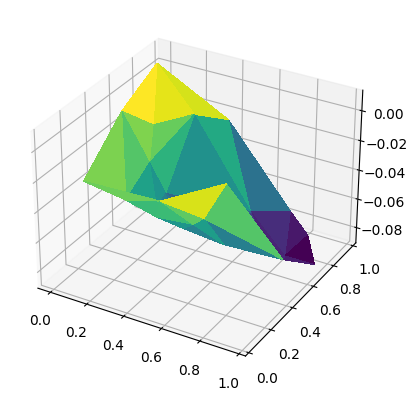

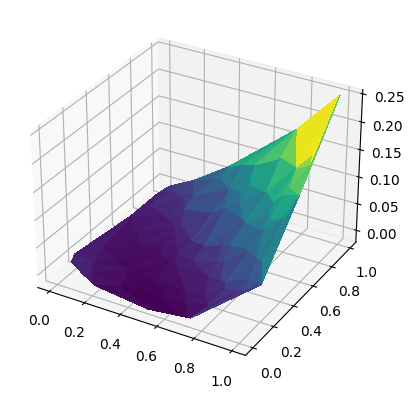

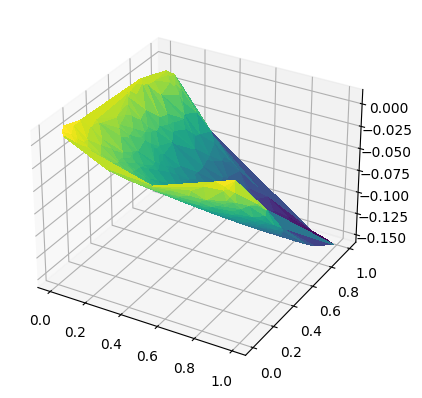

In [71]:
for model_fd, vmodel, n in zip(nonlinear_fd, vanilla_models, N):
    xy = lhs(2, n**2)
    xy_tensor = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy_tensor).detach().cpu().view(-1).numpy()
    error_l2_interpolated = model_fd.computeErrorL2InPoints(xy, u_pred, method="linear")
    print(f"L2 Norm Error = {error_l2_interpolated:.4g}")

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    # 3D surface plot
    ax.plot_trisurf(xy[:,0], xy[:,1], u_pred, cmap='viridis', antialiased=False, edgecolor='none')

### Vanilla PINN - ReLU
- Hidden neurons = 5
- Hidden layers = 2
- Activation: relu (no activation in output layer)
- Optimizer: Adam
- Learning rate = 1e-4
- No regularization
- Epochs >= 5000

In [72]:
hn, hl = 5, 2
sizes = [2] + [hn] * hl + [1]
activations = [nn.ReLU()] * hl
optimizer = optim.Adam
epochs = 5000
lr = 1e-4
weight_decay = 0
epoch_print=250

In [73]:
# Build models
vanilla_models = [NonLinearPoissonPINN(sizes, activations, device=device) for _ in range(len(N))]
for vmodel in vanilla_models:
    vmodel.to(device)

# Define model and metric files
models_path = [MODELS_PATH + f'vanilla_relu_{n}x{n}.pth' for n in N]
metrics_path = [METRICS_PATH + f'metrics_relu_{n}x{n}.txt' for n in N]

# Pre load the model and metrics if they exist
for vmodel, model_path, metric_path in zip(vanilla_models, models_path, metrics_path):
    if os.path.exists(model_path) and os.path.exists(metric_path):
        vmodel.load(model_path, metric_path)

In [74]:
for i, vmodel in enumerate(vanilla_models):
    vmodel.fit(train_dataloader=train_dl[i], optimizer=optimizer, epochs=epochs, lr=lr,
               regularization=weight_decay, val_dataloader=val_dl[i], epoch_print=epoch_print)
    vmodel.save(model_path=models_path[i], metrics_path=metrics_path[i])
    print("-" * 50)

Epoch 250/5001: Loss (6.73, 3.489)
Epoch 500/5001: Loss (4.547, 2.37)
Epoch 750/5001: Loss (4.524, 2.28)
Epoch 1000/5001: Loss (4.554, 2.243)
Epoch 1250/5001: Loss (4.308, 2.171)
Epoch 1500/5001: Loss (4.117, 2.065)
Epoch 1750/5001: Loss (3.885, 1.945)
Epoch 2000/5001: Loss (3.684, 1.814)
Epoch 2250/5001: Loss (3.404, 1.696)
Epoch 2500/5001: Loss (3.284, 1.584)
Epoch 2750/5001: Loss (3.014, 1.488)
Epoch 3000/5001: Loss (2.761, 1.394)
Epoch 3250/5001: Loss (2.646, 1.313)
Epoch 3500/5001: Loss (2.444, 1.257)
Epoch 3750/5001: Loss (2.369, 1.175)
Epoch 4000/5001: Loss (2.272, 1.144)
Epoch 4250/5001: Loss (2.158, 1.069)
Epoch 4500/5001: Loss (2.202, 1.072)
Epoch 4750/5001: Loss (2.035, 1.041)
Epoch 5000/5001: Loss (2.078, 1.016)
--------------------------------------------------
Epoch 250/5001: Loss (9.91, 3.775)
Epoch 500/5001: Loss (5.638, 2.096)
Epoch 750/5001: Loss (4.699, 1.742)
Epoch 1000/5001: Loss (4.214, 1.583)
Epoch 1250/5001: Loss (3.92, 1.491)
Epoch 1500/5001: Loss (3.861, 1.482

In [75]:
for i, (vmodel, n) in enumerate(zip(vanilla_models, N)):
    eps = vmodel.metrics['epochs']
    loss = vmodel.metrics['loss']
    filename = FIGURES_PATH + f"loss_nlp_vanilla_relu_{n}x{n}.png"
    
    fig, ax = plt.subplots(1)
    ax.plot(eps, loss['train']['bc'], 'b-', label="Train - BC")
    ax.plot(eps, loss['val']['bc'], 'b--', label="Val - BC")
    ax.plot(eps, loss['train']['domain'], 'r-', label="Train - Domain")
    ax.plot(eps, loss['val']['domain'], 'r--', label="Val - Domain")
    ax.plot(eps, loss['train']['total'], 'g-', label="Train")
    ax.plot(eps, loss['val']['total'], 'g--', label="Val")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f"Vanilla PINN - Poisson No Lineal - ReLU - Grilla {n}x{n}")

    plt.tight_layout()
    plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
    plt.close()

In [76]:
for model_fd, vmodel in zip(nonlinear_fd, vanilla_models):
    xy = model_fd.domain.getCoords()
    xy = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy).detach().cpu().view(-1).numpy()
    error_l2 = model_fd.computeErrorL2(values=u_pred)
    print(f"L2 Norm Error = {error_l2:.4g}")

L2 Norm Error = 0.8594
L2 Norm Error = 0.9087
L2 Norm Error = 0.8372


In [77]:
for model_fd, vmodel, n in zip(nonlinear_fd, vanilla_models, N):
    xy = lhs(2, n**2)
    xy_tensor = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy_tensor).detach().cpu().view(-1).numpy()
    error_l2_interpolated = model_fd.computeErrorL2InPoints(xy, u_pred, method="nearest")
    print(f"L2 Norm Error = {error_l2_interpolated:.4g}")

L2 Norm Error = 0.8496
L2 Norm Error = 0.9076
L2 Norm Error = 0.8319


### Vanilla PINN - Sigmoid
- Hidden neurons = 5
- Hidden layers = 2
- Activation: relu (no activation in output layer)
- Optimizer: Adam
- Learning rate = 1e-4
- No regularization
- Epochs >= 5000

In [78]:
hn, hl = 5, 2
sizes = [2] + [hn] * hl + [1]
activations = [nn.Sigmoid()] * hl
optimizer = optim.Adam
epochs = 5000
lr = 1e-4
weight_decay = 0
epoch_print=250

In [79]:
# Build models
vanilla_models = [NonLinearPoissonPINN(sizes, activations, device=device) for _ in range(len(N))]
for vmodel in vanilla_models:
    vmodel.to(device)

# Define model and metric files
models_path = [MODELS_PATH + f'vanilla_sigmoid_{n}x{n}.pth' for n in N]
metrics_path = [METRICS_PATH + f'metrics_sigmoid_{n}x{n}.txt' for n in N]

# Pre load the model and metrics if they exist
for vmodel, model_path, metric_path in zip(vanilla_models, models_path, metrics_path):
    if os.path.exists(model_path) and os.path.exists(metric_path):
        vmodel.load(model_path, metric_path)

In [80]:
for i, vmodel in enumerate(vanilla_models):
    vmodel.fit(train_dataloader=train_dl[i], optimizer=optimizer, epochs=epochs, lr=lr,
               regularization=weight_decay, val_dataloader=val_dl[i], epoch_print=epoch_print)
    vmodel.save(model_path=models_path[i], metrics_path=metrics_path[i])
    print("-" * 50)

Epoch 250/5001: Loss (6.611, 3.111)
Epoch 500/5001: Loss (3.695, 1.671)
Epoch 750/5001: Loss (2.275, 1.003)
Epoch 1000/5001: Loss (1.63, 0.705)
Epoch 1250/5001: Loss (1.341, 0.5809)
Epoch 1500/5001: Loss (1.202, 0.5299)
Epoch 1750/5001: Loss (1.123, 0.5035)
Epoch 2000/5001: Loss (1.078, 0.482)
Epoch 2250/5001: Loss (1.027, 0.4574)
Epoch 2500/5001: Loss (0.9587, 0.4266)
Epoch 2750/5001: Loss (0.8567, 0.3873)
Epoch 3000/5001: Loss (0.7724, 0.3392)
Epoch 3250/5001: Loss (0.6285, 0.2832)
Epoch 3500/5001: Loss (0.4978, 0.2221)
Epoch 3750/5001: Loss (0.3718, 0.1613)
Epoch 4000/5001: Loss (0.2435, 0.1085)
Epoch 4250/5001: Loss (0.1574, 0.06825)
Epoch 4500/5001: Loss (0.1021, 0.04279)
Epoch 4750/5001: Loss (0.07568, 0.03044)
Epoch 5000/5001: Loss (0.07109, 0.02568)
--------------------------------------------------
Epoch 250/5001: Loss (4.038, 1.496)
Epoch 500/5001: Loss (3.783, 1.405)
Epoch 750/5001: Loss (3.407, 1.27)
Epoch 1000/5001: Loss (2.858, 1.079)
Epoch 1250/5001: Loss (2.263, 0.876)


In [81]:
for i, (vmodel, n) in enumerate(zip(vanilla_models, N)):
    eps = vmodel.metrics['epochs']
    loss = vmodel.metrics['loss']
    filename = FIGURES_PATH + f"loss_nlp_vanilla_sigmoid_{n}x{n}.png"
    
    fig, ax = plt.subplots(1)
    ax.plot(eps, loss['train']['bc'], 'b-', label="Train - BC")
    ax.plot(eps, loss['val']['bc'], 'b--', label="Val - BC")
    ax.plot(eps, loss['train']['domain'], 'r-', label="Train - Domain")
    ax.plot(eps, loss['val']['domain'], 'r--', label="Val - Domain")
    ax.plot(eps, loss['train']['total'], 'g-', label="Train")
    ax.plot(eps, loss['val']['total'], 'g--', label="Val")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_title(f"Vanilla PINN - Poisson No Lineal - Sigmoid - Grilla {n}x{n}")

    plt.tight_layout()
    plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
    plt.close()

In [82]:
for model_fd, vmodel in zip(nonlinear_fd, vanilla_models):
    xy = model_fd.domain.getCoords()
    xy = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy).detach().cpu().view(-1).numpy()
    error_l2 = model_fd.computeErrorL2(values=u_pred)
    print(f"L2 Norm Error = {error_l2:.4g}")

L2 Norm Error = 0.489
L2 Norm Error = 0.6494
L2 Norm Error = 0.5358


In [83]:
for model_fd, vmodel, n in zip(nonlinear_fd, vanilla_models, N):
    xy = lhs(2, n**2)
    xy_tensor = torch.tensor(xy, dtype=torch.float32, device=device)
    u_pred = vmodel.forward(xy_tensor).detach().cpu().view(-1).numpy()
    error_l2_interpolated = model_fd.computeErrorL2InPoints(xy, u_pred, method="nearest")
    print(f"L2 Norm Error = {error_l2_interpolated:.4g}")

L2 Norm Error = 0.4629
L2 Norm Error = 0.5946
L2 Norm Error = 0.5219
